# Emulate using linear interpolation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import linear_emulator

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [2]:
emulate_pressure=True
emulate_growth=False
emulate_running=False
# option to load only a fraction of redshifts from simulations
undersample_z=3
emu=linear_emulator.LinearEmulator(undersample_z=undersample_z,
                                   emulate_running=emulate_running,emulate_pressure=emulate_pressure,
                                   emulate_growth=emulate_growth,max_arxiv_size=1000,verbose=True)
#emu=linear_emulator.LinearEmulator(max_arxiv_size=1000,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

### Interpolate to a particular point in parameter space

In [3]:
# identify mean model
median_mF=np.median(emu.arxiv.mF)
median_sigT_Mpc=np.median(emu.arxiv.sigT_Mpc)
median_gamma=np.median(emu.arxiv.gamma)
median_kF_Mpc=np.median(emu.arxiv.kF_Mpc)
median_Delta2_p=np.median(emu.arxiv.Delta2_p)
median_n_p=np.median(emu.arxiv.n_p)
median_alpha_p=np.median(emu.arxiv.alpha_p)
median_f_p=np.median(emu.arxiv.f_p)
median_model={'mF':median_mF,'sigT_Mpc':median_sigT_Mpc,'gamma':median_gamma,'kF_Mpc':median_kF_Mpc,
            'Delta2_p':median_Delta2_p,'n_p':median_n_p,'alpha_p':median_alpha_p,'f_p':median_f_p}
print('mean model =',median_model)

mean model = {'mF': 0.67885698415399398, 'sigT_Mpc': 0.14451309942395926, 'gamma': 1.437777132617994, 'kF_Mpc': 12.693683029232602, 'Delta2_p': 0.33196737106168711, 'n_p': -2.3000000281110902, 'alpha_p': -0.21000052205110478, 'f_p': 0.98087751105439069}


In [4]:
k_Mpc=np.logspace(-1,1,100)
p1d=emu.emulate_p1d_Mpc(median_model,k_Mpc)

asked to emulate model {'mF': 0.67885698415399398, 'sigT_Mpc': 0.14451309942395926, 'gamma': 1.437777132617994, 'kF_Mpc': 12.693683029232602, 'Delta2_p': 0.33196737106168711, 'n_p': -2.3000000281110902, 'alpha_p': -0.21000052205110478, 'f_p': 0.98087751105439069}
evaluate point [  0.33196737  -2.30000003   0.67885698   0.1445131    1.43777713
  12.69368303]
got coefficients [-0.02553496 -0.12708458 -0.28823198 -0.67235117 -1.18392458]


Text(0.5, 0, '$k_\\parallel$ [1/Mpc]')

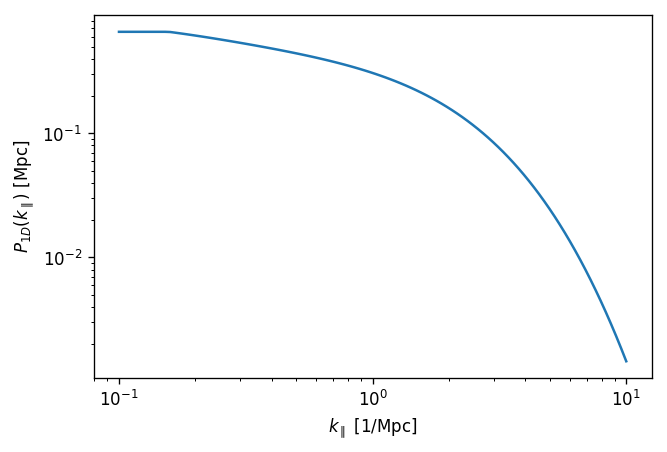

In [5]:
plt.loglog(k_Mpc,p1d)
plt.ylabel(r'$P_{1D}(k_\parallel)$ [Mpc]')
plt.xlabel(r'$k_\parallel$ [1/Mpc]')

In [6]:
emu.verbose=False
emu.arxiv.verbose=False

In [7]:
def plot_p1d_dependence(emu,median_model,param,xmin,xmax):

    # deep copy of dictionary (thread safe, why not)
    model = json.loads(json.dumps(median_model))
    
    k_Mpc=np.logspace(-1,1,100)
    plt.figure()
    # define range of parameter values to explore    
    Nx=100
    xs=np.linspace(xmin,xmax,Nx)
    for i in range(Nx):
        x=xs[i]
        model[param]=x
        p1d_Mpc = emu.emulate_p1d_Mpc(model,k_Mpc)
        col = plt.cm.jet((x-xmin)/(xmax-xmin))
        if i in [0,Nx-1]:
            label=param+' = %f'%xs[i]
        else:
            label=None
        plt.semilogx(k_Mpc,k_Mpc*p1d_Mpc,color=col,label=label)
        
    plt.xlabel(r'$k_\parallel$ [1/Mpc]')
    plt.ylabel(r'$k_\parallel \quad P_{\rm 1D}(k_\parallel)$')
    plt.legend()
    plt.title(r'P1D as a function of '+param)
    return

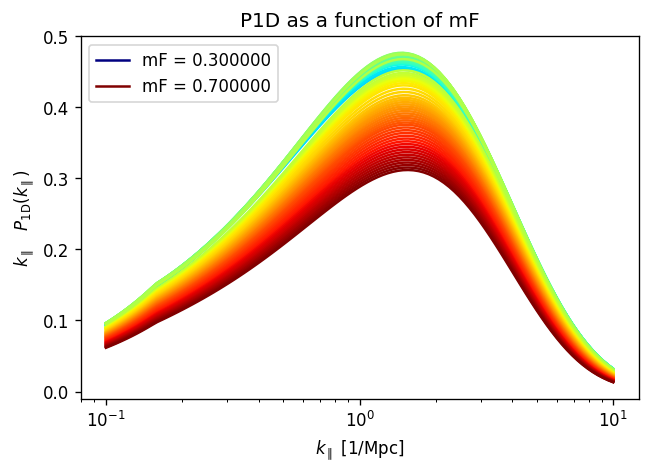

In [8]:
plot_p1d_dependence(emu,median_model,'mF',0.3,0.7)

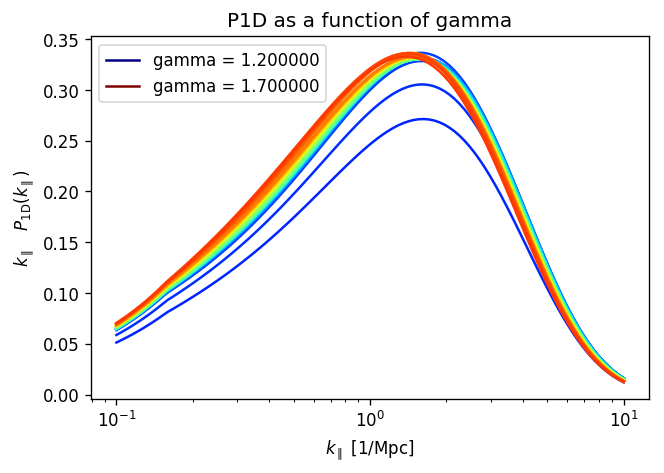

In [9]:
plot_p1d_dependence(emu,median_model,'gamma',1.2,1.7)

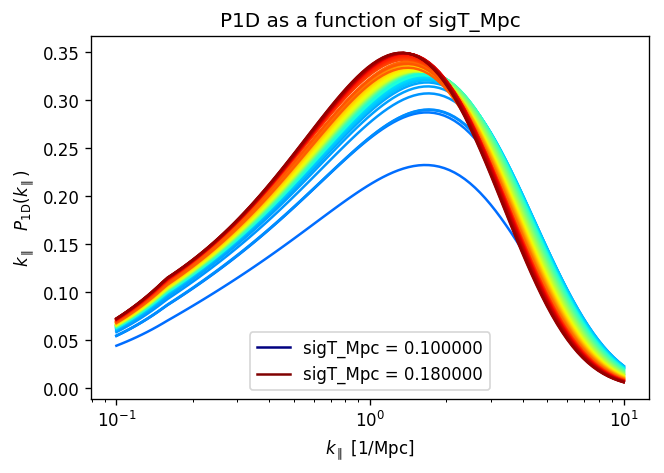

In [10]:
plot_p1d_dependence(emu,median_model,'sigT_Mpc',0.10,0.18)

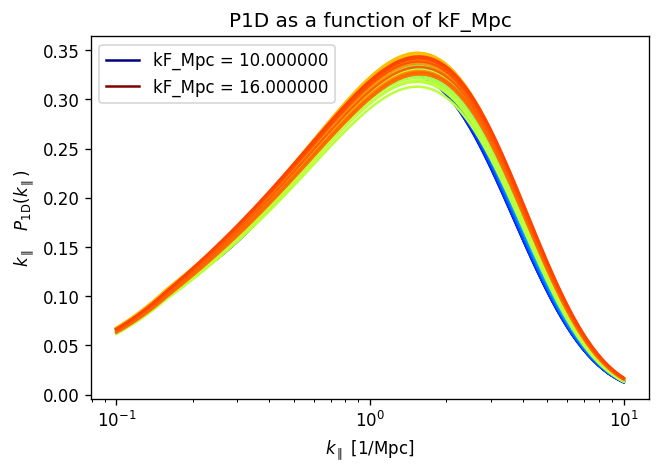

In [11]:
if emulate_pressure:
    plot_p1d_dependence(emu,median_model,'kF_Mpc',10,16)

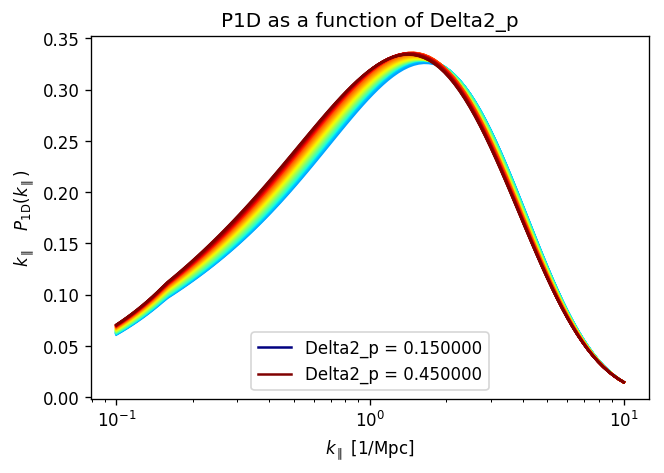

In [12]:
plot_p1d_dependence(emu,median_model,'Delta2_p',0.15,0.45)

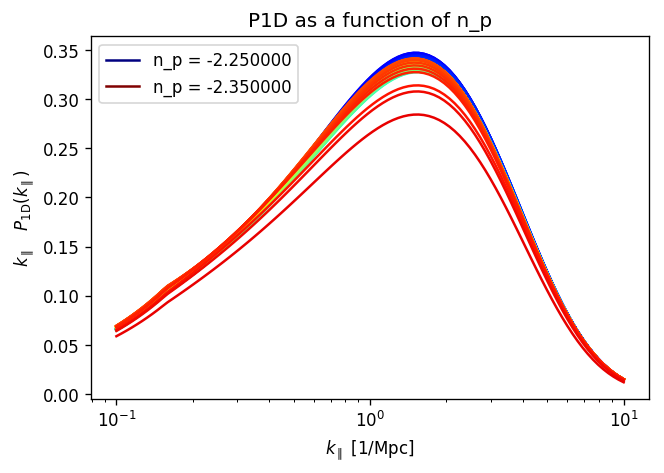

In [13]:
plot_p1d_dependence(emu,median_model,'n_p',-2.25,-2.35)

In [14]:
if emulate_running:
    plot_p1d_dependence(emu,median_model,'alpha_p',-0.19,-0.23)

In [15]:
if emulate_growth:
    plot_p1d_dependence(emu,median_model,'f_p',0.97,0.99)